# Detección de neurovascularización coroidea

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os

Definiendo rutas y el tamaño de las imagenes a usar

In [2]:
imsize = 150
train_path = '../input/kermany2018/OCT2017 /train/'
test_path = '../input/kermany2018/OCT2017 /test/'
val_path = '../input/kermany2018/OCT2017 /val/'

Método para cargar el dataset

In [3]:
from tqdm import tqdm
from skimage import transform

def load_data(path):
    '''
    A partir de una dirección retorna data, target
    
    path -- dirección de la carpeta
    
    return:
    X -- lista que contiene las imagenes de entrada
    y -- lista que contiene los target
    '''
    
    X = []
    y = []

    for f in os.listdir(path):
        if not f.startswith('.'):
            if f in ['NORMAL', 'CNV']:
                
                count = 0
                               
                if f in ['NORMAL']:
                    label = 0
                else: 
                    label = 1
                    
                for image in tqdm(os.listdir(path + f)):
                    
                    count += 1
                    
                    if count > 2800:
                        break
                    
                    #print(path + f + '/' + image)
                    
                    img = cv2.imread(path + f + '/' + image)
                    
                    if img is not None:
                        img = transform.resize(img, (imsize, imsize, 3))
                        img = np.asarray(img)
                        
                        X.append(img)
                        y.append(label)
        
    return np.asarray(X), np.asarray(y)

In [4]:
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)
X_val, y_val = load_data(val_path)

y_train_c = y_train

100%|██████████| 8/8 [00:00<00:00, 35.65it/s]


One hot encoding

In [5]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Ejemplo de histograma de una imagen

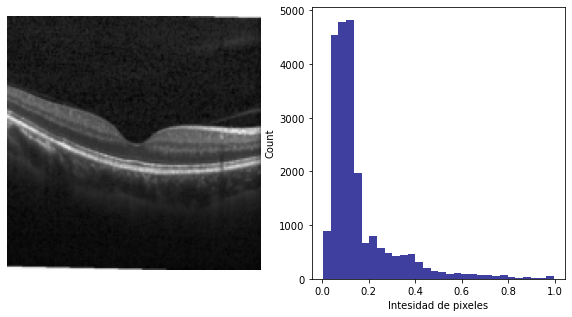

In [6]:
import matplotlib.pyplot as plt

def plotHistogram(a):
    """
    Histograma de la intesidad de los pixeles
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Intesidad de pixeles')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    
plotHistogram(X_train[1])

Método para mostrar varias imagenes al mismo tiempo

Normal


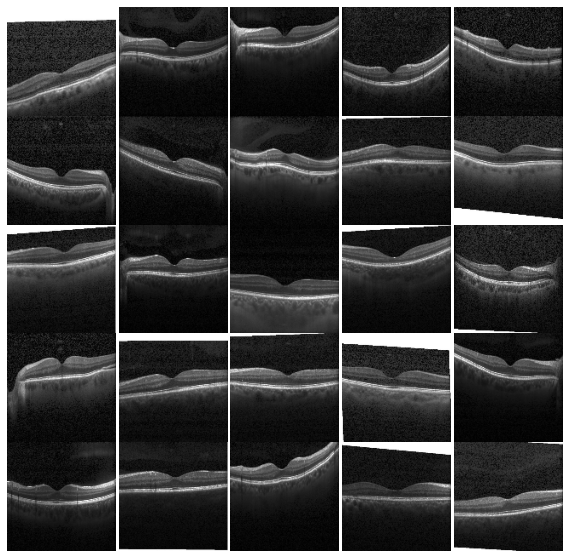

In [7]:
from glob import glob

def plot_images(title, images):
    '''
    Muestra las imagenes
    '''
    
    print(title)
    
    i_ = 0
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for l in images[:25]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1
        
multipleImages = glob('../input/kermany2018/OCT2017 /train/NORMAL/**')
plot_images('Normal', multipleImages)

Cnv


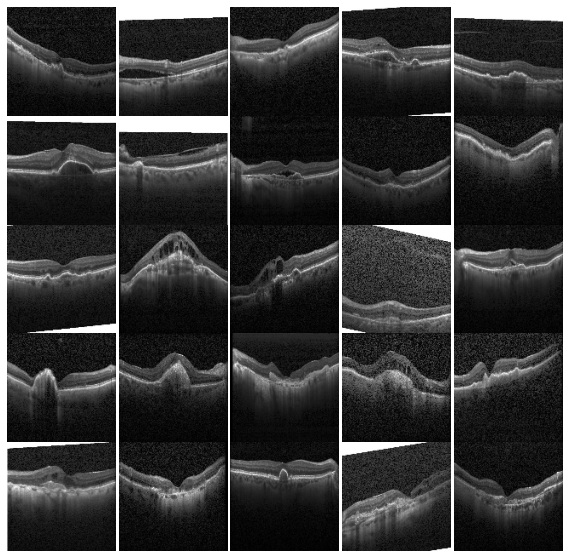

In [8]:
multipleImages = glob('../input/kermany2018/OCT2017 /train/CNV/**')
plot_images('Cnv', multipleImages)

Cantidad de imagenes en el dataset para cada tipo.
{0: 'Normal', 1: 'CNV'}


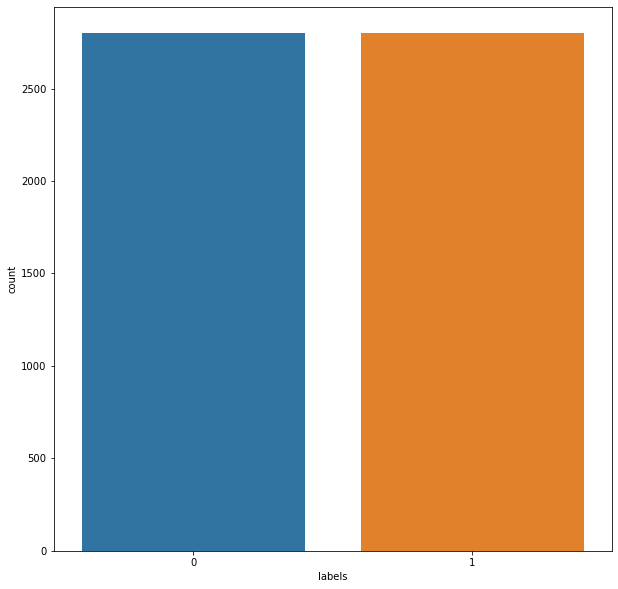

In [9]:
import pandas as pd

print("Cantidad de imagenes en el dataset para cada tipo.")
map_characters = {0: 'Normal', 1: 'CNV'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train_c
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

Método para imprimir la matriz de confusión

In [10]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor real.')
    plt.xlabel('Valor obtenido.')

Cargando modelos a ser usados en transfer learning

In [11]:
import keras

VGG = keras.applications.vgg16.VGG16(include_top= False, weights = 'imagenet', input_shape=(imsize, imsize, 3))
INCEPTION_V3 = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape= (imsize, imsize, 3))

87916544/87910968 [==============================] - 1s 0us/step


Aplicando transfer learning a modelo VGG16

In [12]:
adam = keras.optimizers.Adam()

xv = VGG.output
xv = tf.keras.layers.Flatten()(xv)
xv = tf.keras.layers.Dense(2, activation = 'softmax')(xv)

vggmodel = keras.models.Model(inputs = VGG.input, outputs = xv)

for layer in VGG.layers:
    layer.trainable = False
    
vggmodel.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])

Aplicando transfer learning a modelo INCEPTION V3

In [13]:
adaminc = keras.optimizers.Adam()

xi = INCEPTION_V3.output
xi = tf.keras.layers.Flatten()(xi)
xi = tf.keras.layers.Dense(2, activation = 'softmax')(xi)

incmodel = keras.models.Model(inputs = INCEPTION_V3.input, outputs = xi)

for layer in INCEPTION_V3.layers:
    layer.trainable = False
    
incmodel.compile(loss = 'categorical_crossentropy',
                 optimizer = adam, 
                 metrics = ['accuracy'])

Entrenando los modelos y viendo sus resultados

Resumen del modelo: VGG16 con transfer learning
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2

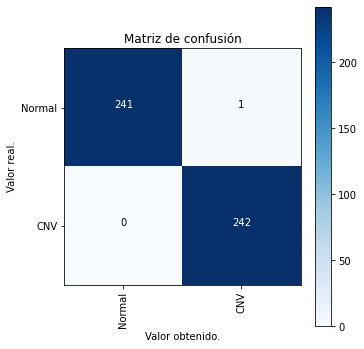

In [14]:
#VGG16
import sklearn
from sklearn.metrics import confusion_matrix

#vggmodel = vggc

print('Resumen del modelo: VGG16 con transfer learning')
vggmodel.summary()

_ = vggmodel.fit(X_train,y_train, epochs= 3, validation_data=(X_test,y_test), verbose=1)


scoreVGG = vggmodel.evaluate(X_test,y_test, verbose=0)

print('\nKeras CNN - precisión:', scoreVGG[1], '\n')
y_pred = vggmodel.predict(X_test, verbose= 1)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=['Normal', 'CNV']), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes =['Normal', 'CNV'])
plt.show()

Resumen del modelo: INCEPTION V3 con transfer learning
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________

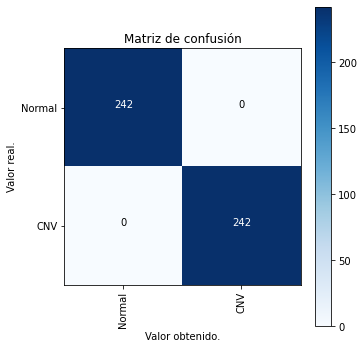

In [15]:
#INCEPTION V3

#incmodel = incc 

print('Resumen del modelo: INCEPTION V3 con transfer learning')
incmodel.summary()
print(X_train.shape)
_ = incmodel.fit(X_train,y_train, epochs= 3, validation_data=(X_test,y_test), verbose=1, batch_size= 128)


scoreINC = incmodel.evaluate(X_test,y_test, verbose=1)

print('\nKeras CNN - precisión:', scoreINC[1], '\n')
y_pred = incmodel.predict(X_test, verbose= 1)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=['Normal', 'CNV']), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes =['Normal', 'CNV'])
plt.show()

100%|██████████| 26315/26315 [01:49<00:00, 240.08it/s]


175/175 - 6s - loss: 0.0701 - accuracy: 0.9768

Keras CNN - precisión: 0.9767774343490601 

175/175 [==============================] - 6s 34ms/step

              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98      2799
         CNV       0.98      0.97      0.98      2799

    accuracy                           0.98      5598
   macro avg       0.98      0.98      0.98      5598
weighted avg       0.98      0.98      0.98      5598



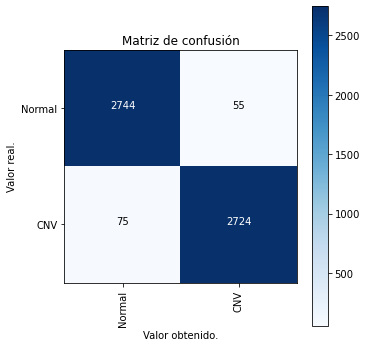

175/175 - 6s - loss: 0.2023 - accuracy: 0.9689

Keras CNN - precisión: 0.9689174890518188 

175/175 [==============================] - 5s 29ms/step

              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      2799
         CNV       0.98      0.96      0.97      2799

    accuracy                           0.97      5598
   macro avg       0.97      0.97      0.97      5598
weighted avg       0.97      0.97      0.97      5598



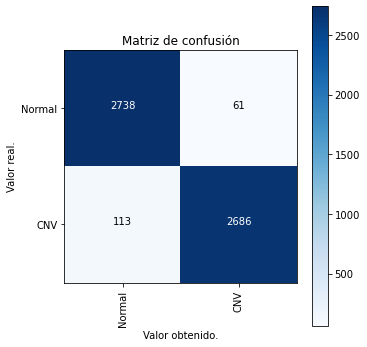

In [16]:

X_train = None
y_train = None

X_eval_2 = []
y_eval_2 = []

path = train_path 
for f in os.listdir(path):
    if not f.startswith('.'):
        if f in ['NORMAL', 'CNV']:
               
            count = 0
                               
            if f in ['NORMAL']:
                label = 0
            else: 
                label = 1
                    
            for image in tqdm(os.listdir(path + f)):
                    
                count += 1
                    
                if count < 2800:
                    pass
                elif 2800 < count and count < 5600:
                                       
                    img = cv2.imread(path + f + '/' + image)
                    
                    if img is not None:
                        img = transform.resize(img, (imsize, imsize, 3))
                        img = np.asarray(img)
                        
                        X_eval_2.append(img)
                        y_eval_2.append(label)

X_eval_2 = np.asarray(X_eval_2)
y_eval_2 = np.asarray(y_eval_2)
y_eval_2 = to_categorical(y_eval_2)
score = vggmodel.evaluate(X_eval_2,y_eval_2, verbose=2)
print('\nKeras CNN - precisión:', score[1], '\n')
y_pred = vggmodel.predict(X_eval_2, verbose= 1)
print('\n', sklearn.metrics.classification_report(np.where(y_eval_2 > 0)[1], np.argmax(y_pred, axis=1), target_names=['Normal', 'CNV']), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_eval_2,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes =['Normal', 'CNV'])
plt.show()

score = incmodel.evaluate(X_eval_2, y_eval_2, verbose=2)
print('\nKeras CNN - precisión:', score[1], '\n')
y_pred = incmodel.predict(X_eval_2, verbose= 1)
print('\n', sklearn.metrics.classification_report(np.where(y_eval_2 > 0)[1], np.argmax(y_pred, axis=1), target_names=['Normal', 'CNV']), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_eval_2,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes =['Normal', 'CNV'])
plt.show()

In [17]:
vggmodel.save('vggmodel')
incmodel.save('incmodel')